### Лабораторная работа №8. Рекуррентные нейронные сети для анализа временных рядов

Данные: Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/

Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.

Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

Задание 5.
Сравните качество прогноза моделей.

Какой максимальный результат удалось получить на контрольной выборке?
Результат выполнения заданий опишите в отчете.


In [1]:
!unzip sunspots.zip

Archive:  sunspots.zip
  inflating: Sunspots.csv            


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./Sunspots.csv", index_col="Date", parse_dates=True).drop(columns="Unnamed: 0")
df["Values"] = df["Monthly Mean Total Sunspot Number"].copy()
del df["Monthly Mean Total Sunspot Number"]

df

,Values
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


In [3]:
df.index

DatetimeIndex(['1749-01-31', '1749-02-28', '1749-03-31', '1749-04-30',
               '1749-05-31', '1749-06-30', '1749-07-31', '1749-08-31',
               '1749-09-30', '1749-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=3252, freq=None)

Основные характеристики

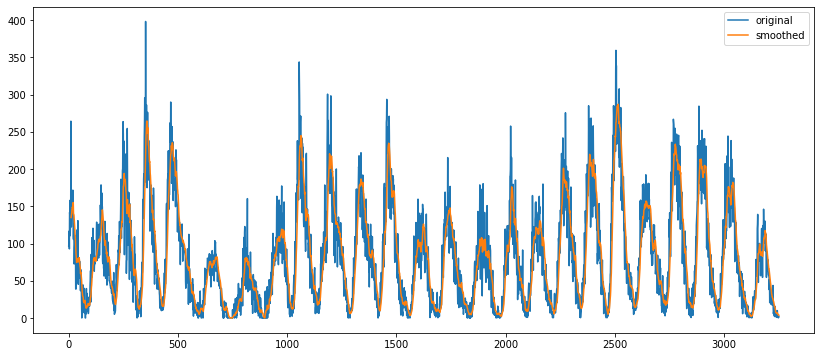

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(df)), df.Values, label="original")
plt.plot(np.arange(len(df)), df.Values.rolling(12).mean(), label="smoothed")
plt.legend()
plt.show()

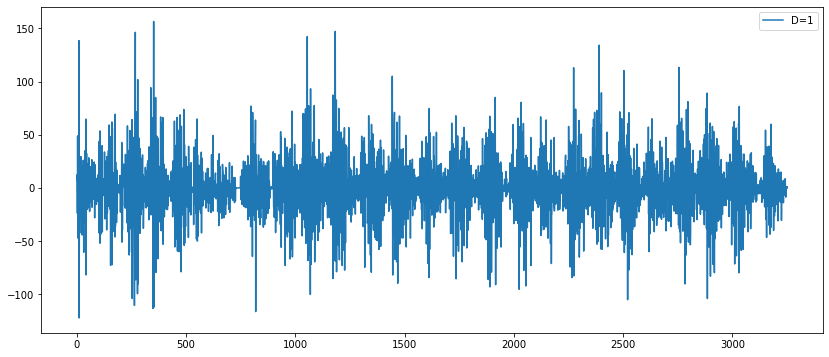

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(df)), df.Values.diff(), label="D=1")
plt.legend()
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

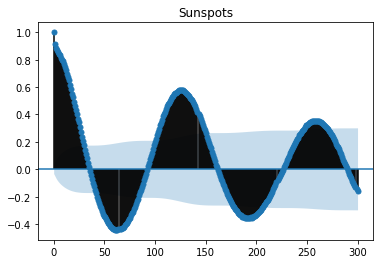

In [7]:
plot_acf(df.Values,lags=300,title='Sunspots')
plt.show()

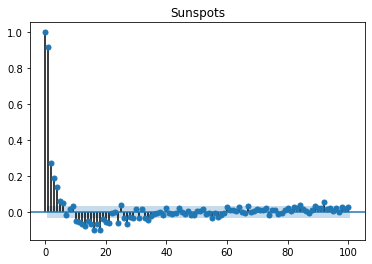

In [8]:
plot_pacf(df.Values,lags=100,title='Sunspots')
plt.show()

Train / test / validation 

In [9]:
random_state = 42
test_size = 0.15
validation_size = 0.15

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, shuffle=False)
train_df, test_df = train_df.copy(), test_df.copy()

train_df, valid_df = train_test_split(train_df, test_size=validation_size, random_state=random_state, shuffle=False)
train_df, valid_df = train_df.copy(), valid_df.copy()

ARIMA

In [11]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [12]:
# model = SARIMAX(train_df.Values, trend="n", freq="M", order=(7, 0, 30), seasonal_order=(1, 1, 0, 11 * 12))
model = ARIMA(train_df.Values, freq="M", order=(7, 0, 1))

results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                 Values   No. Observations:                 2349
Model:                     ARMA(7, 1)   Log Likelihood              -10892.842
Method:                       css-mle   S.D. of innovations             24.972
Date:                Sat, 18 Apr 2020   AIC                          21805.683
Time:                        19:34:41   BIC                          21863.301
Sample:                    01-31-1749   HQIC                         21826.667
                         - 09-30-1944                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           76.3396      5.082     15.021      0.000      66.378      86.301
ar.L1.Values     1.4990      0.022     68.494      0.000       1.456       1.542
ar.L2.Values    -0.3953      0.037    -10.57

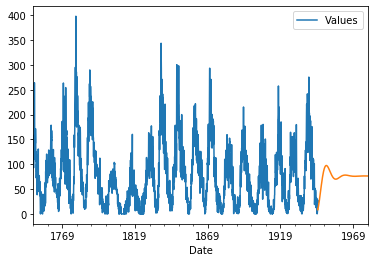

In [13]:
forecast = results.predict(start=train_df.index[-2], end=train_df.index[-2] + pd.DateOffset(months=len(valid_df)), dynamic=True) 
train_df.plot()
forecast.plot()
plt.show()

RNN

In [14]:
value_mean = train_df.Values.mean()
value_std = train_df.Values.std()

for target_df in (train_df, valid_df, test_df):
    target_df["Values_normalized"] = (target_df.Values - value_mean) / value_std

train_df

,Values,Values_normalized
Date,,
1749-01-31,96.7,0.315771
1749-02-28,104.3,0.435633
1749-03-31,116.7,0.631196
1749-04-30,92.8,0.254263
1749-05-31,141.7,1.025477
...,...,...
1944-05-31,4.1,-1.144645
1944-06-30,8.2,-1.079983
1944-07-31,8.5,-1.075252


In [15]:
def dataset_from_series(df, lookback_period=12):
    X, y = [], []

    for idx in range(lookback_period, len(df)):
        history_vector = np.array(df["Values_normalized"][idx-lookback_period:idx], dtype=np.float32)
        next_value = df["Values_normalized"][idx]
        
        X.append(history_vector)
        y.append(next_value)
    
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)
    
    y = np.array(y)
    
    return X, y

In [16]:
BATCH_SIZE = 256

In [17]:
train_data = tf.data.Dataset.from_tensor_slices(dataset_from_series(train_df))
train_data = train_data.shuffle(10000).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices(dataset_from_series(valid_df))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(12, input_shape=(12, 1), return_sequences=True),
    tf.keras.layers.GRU(12),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 12)            540       
_________________________________________________________________
gru_1 (GRU)                  (None, 12)                936       
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    steps_per_epoch=100,
    validation_steps=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Train for 100 steps, validate for 30 steps
Epoch 1/100
100/100 [==============================] - 6s 62ms/step - loss: 0.3716 - val_loss: 0.2363
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.1776 - val_loss: 0.2090
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.1684 - val_loss: 0.1895
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.1636 - val_loss: 0.1805
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 0.1583 - val_loss: 0.1772
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.1578 - val_loss: 0.1782
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.1589 - val_loss: 0.1722
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.1565 - val_loss: 0.1723
Epoch 9/100
100/100 [==============================] - 1s 7ms/step - loss: 0.1555 - val_loss: 0.1721
Epoch 10/100
100/100 [=========================

Evaluate on test data

In [20]:
x_test, y_test = dataset_from_series(test_df)

In [21]:
model.evaluate(x=x_test, y=y_test)

476/476 [==============================] - 1s 3ms/sample - loss: 0.1316


0.131639156380997

In [30]:
y_pred = [np.nan] * 12 + (value_mean + model.predict(x_test) * value_std).flatten().tolist()

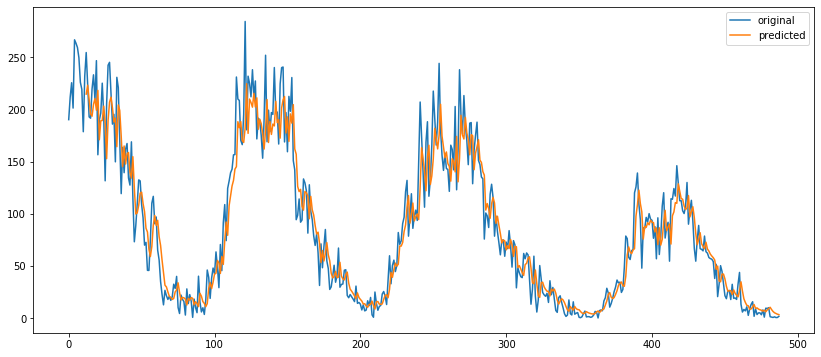

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(test_df)), test_df.Values, label="original")
plt.plot(np.arange(len(test_df)), y_pred, label="predicted")
plt.legend()
plt.show()